<a href="https://colab.research.google.com/github/paulynamagana/AFDB_scripts/blob/main/alphamissense_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Colab notebook

Provide input: You'll need to provide:
* A list of UniProt IDs.


1. To run a code cell, click on the cell to select it. You will notice a play button (▶️) on the left side of the cell. Click on the play button or press Shift+Enter to run the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it. If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.


In [14]:
import logging
import os
import sys
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def fetch_AFDB_data(uniprot_accession):
    """Fetches data from the AlphaFold Database API.

    Args:
        uniprot_accession (str): The UniProt accession code.

    Returns:
        dict or None: The JSON result, or None on error.
    """
    url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_accession}"
    try:
        logging.info(f"Fetching data for {uniprot_accession}")
        response = requests.get(url)
        response.raise_for_status()
        logging.info(f"Successfully retrieved data for {uniprot_accession}")
        return response.json()

    except requests.exceptions.RequestException as e:
        logging.error(f"Error retrieving data for {uniprot_accession}, check UniProt accession")
        return None


def extract_alpha_missense_url(data):
    """Extracts the AlphaMissense URL from the API data.

    Args:
        data (dict): The JSON data from the API.

    Returns:
        str: The AlphaMissense URL, or an error message.
    """
    if data:
        logging.info(f"Retrieving AM data")
        return data[0].get('amAnnotationsUrl', f"No AlphaMissense data for this protein.")
    else:
        return "Error: No data provided."


def extract_pdb_url(data):
    """Extracts the PDB URL from the API data.

    Args:
        data (dict): The JSON data from the API.

    Returns:
        str: The PDB url, or an error message.
    """
    if data:
        logging.info(f"Retrieving url for PDB file")
        return data[0].get('pdbUrl', "Failed to retrieve PDB URL.")
    else:
        return "Error: No data provided."


def extract_am_data(am_url):
    """
    Extract AlphaMissense data from the url and saves it as a CSV file
    """
    try:
        am_file = pd.read_csv(am_url)
    except Exception as e:
        logging.error(f"Error reading AM file: {e}")
        return None

    reference_aa = am_file["protein_variant"].str.extract(r'^([A-Z])')[0]
    alternative_aa = am_file["protein_variant"].str.extract('([A-Z])$')[0]
    residue_number = pd.to_numeric(am_file["protein_variant"].str.extract(r'([0-9]+)')[0])
    pathogenicity_score = pd.to_numeric(am_file['am_pathogenicity'])

    am_data = pd.DataFrame({
        'reference_aa': reference_aa,
        'residue_number': residue_number,
        "alternative_aa":alternative_aa,
        "pathogenicity_score": pathogenicity_score})

    output_directory = "data_output"
    ensure_directory_exists(output_directory)
    output_filename = os.path.basename(am_url)
    output_file = os.path.join(output_directory, output_filename)


    try:
        am_data.to_csv(output_file, index=False)
        logging.info(f"AM data saved to: {output_filename}")
    except Exception as e:
        logging.error(f"Error saving AM data: {e}")

    return am_data

def calculate_average_pathogenicity(am_data):
    """Calculates average pathogenicity scores per residue from AM data
    """
    if am_data is None:
        logging.error("No AlphaMissense data available")
        return None

    grouped = am_data.groupby(['residue_number'])['pathogenicity_score'].mean().reset_index()
    max_residue_number = grouped['residue_number'].max()
    average_scores = np.full(max_residue_number + 1, np.nan)

    for _, row in grouped.iterrows():
        residue_number = int(row['residue_number'])
        average_scores[residue_number] = round(row['pathogenicity_score'], 4)
    return average_scores


def modify_pdb_with_am_data(pdb_url, average_scores_file):

    if pdb_url:
        try:
            logging.info("Retrieving PDB file")
            pdb_content = requests.get(pdb_url).text.splitlines()
        except requests.exceptions.RequestException as e:
            logging.error(f"Failed to retrieve the PDB file: {e}")

    output_directory = "data_output"
    ensure_directory_exists(output_directory)

    base_filename = os.path.basename(pdb_url)
    output_filename = f"AM_scores_{base_filename}"
    output_file = os.path.join(output_directory, output_filename)

    try:
        logging.info(f"Writing modified PDB data to: {output_file}")
        with open(output_file, "w", encoding= "utf-8") as out_file:
            for line in pdb_content:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                    residue_number = int(line[22:26].strip())
                    if residue_number < len(average_scores_file) and not np.isnan(average_scores_file[residue_number]):
                        value = average_scores_file[residue_number]
                        value_str = f"{value:.2f}"
                        while len(value_str) < 6:
                            value_str = " " + value_str
                        edit_line = line[:60] + value_str + line[66:]
                        out_file.write(edit_line + '\n')
                    else:
                        out_file.write(line + '\n')
                else:
                    out_file.write(line + '\n')
    except IOError as e:
        logging.error(f"Error writing to file: {e}")


def extract_pathogenicity_and_plddt(am_file_path, pdb_file_url):
    """
    Extracts pathogenicity scores from an AM file and pLDDT values from a PDB file URL.

    Args:
    am_file_path (str): Path to the AM file containing pathogenicity scores.
    pdb_file_url (str): URL of the PDB file containing pLDDT values.

    Returns:
    tuple: Two lists:
    - pathogenicity_scores (list): List of pathogenicity scores.
    - plddt_scores (list): List of pLDDT scores.
    """
    pathogenicity_scores = []
    plddt_scores = []

    # Extract Pathogenicity Scores from AM File
    try:
        with open(am_file_path, "r") as f:
            am_pdb = f.read()

        for line in am_pdb.splitlines():
            if line.startswith(("ATOM", "HETATM")):
                pathogenicity_scores.append(float(line[60:66].strip()))

    except FileNotFoundError:
        logging.error(f"AM file not found: {am_file_path}")
    except ValueError:
        logging.error("Error parsing pathogenicity scores in the AM file.")

    # Extract pLDDT Scores from PDB URL
    if pdb_file_url:
        logging.info(f"Fetching PDB data from {pdb_file_url}")

        try:
            response = requests.get(pdb_file_url)
            response.raise_for_status()
            pdb_content = response.text.splitlines()

            for line in pdb_content:
                if line.startswith(("ATOM", "HETATM")):
                    plddt_scores.append(float(line[60:66].strip()))

        except requests.exceptions.RequestException as e:
            logging.error(f"Error fetching PDB data: {e}")
        except ValueError:
            logging.error("Error parsing pLDDT scores in the PDB file.")

    return pathogenicity_scores, plddt_scores




def plot_scores(pathogenicity_scores, plddt_scores, uniprot_id):
    """
    Plots pathogenicity and rescaled pLDDT scores against residue number using Seaborn.

    Args:
        pathogenicity_scores (list): List of pathogenicity scores.
        plddt_scores (list): List of pLDDT scores.
    """

    # Rescale pLDDT scores from 0-100 to 0-1
    plddt_rescaled = [score / 100 for score in plddt_scores]

    # Create a DataFrame for easy plotting with Seaborn
    data = {
        'Residue number': range(1, len(pathogenicity_scores) + 1),
        'Average pathogenicity': pathogenicity_scores,
        'pLDDT (rescaled)': plddt_rescaled
    }
    df = pd.DataFrame(data)

    # Create line plots with Seaborn
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    sns.lineplot(x='Residue number', y='Average pathogenicity', data=df, label='Average AM score')
    sns.lineplot(x='Residue number', y='pLDDT (rescaled)', data=df, label='pLDDT (rescaled)')

    # Add labels, title, and legend
    plt.xlabel('Residue number')
    plt.ylabel('Score')
    plt.title(f'Average AM and pLDDT scores per position ({uniprot_id})')
    plt.legend()

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=5)

    plt.grid(axis='y', linestyle='--')  # Optional grid

        # Save the plot to a file
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leaves space below for the legend

        # Save the plot to a file
    output_directory = "data_output"
    output_file = os.path.join(output_directory, f"graph_plDDT-AM-score_{uniprot_id}.png")
    plt.savefig(output_file) #save file

    # Show the plot
    plt.show()
    plt.close()


def plot_am_heatmap(am_data, uniprot_id):
    """
    Plots a heatmap for the AlphaMissense data with reference residues on x and alternative_aa on y axis
    Colour coded following the original colours from the AlphaFold Database, see: https://alphafold.ebi.ac.uk/entry/Q5VSL9
    """

    #custom palette
    def create_custom_colormap():
        cdict = {
            'red': [
                (0.0, 56/255, 56/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 165/255, 165/255)
            ],
            'green': [
                (0.0, 83/255, 83/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 13/255, 13/255)
            ],
            'blue': [
                (0.0, 163/255, 163/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 18/255, 18/255)
            ]
        }
        return LinearSegmentedColormap('CustomMap', segmentdata=cdict)

    # custom colormap
    custom_cmap = create_custom_colormap()

    # pivot table
    pivot_table = am_data.pivot_table(values='pathogenicity_score', index='alternative_aa', columns='reference_aa', aggfunc='mean')
    pivot_table = pd.pivot_table(am_data, values='pathogenicity_score',
    index='alternative_aa', columns='residue_number')

    #custom_order = ["R", "H", "K", "D", "E", "S", "T", "N", "Q", "C", "P", "A", "V", "I", "L", "M", "G", "F","Y","W"]

    # Reindex the pivot table
    #pivot_table = pivot_table.reindex(custom_order)

    plt.figure(figsize=(20, 6))

    ax = sns.heatmap(pivot_table, cmap=custom_cmap, vmin=0, vmax=1,
    cbar_kws={'label': 'AlphaMissense score'}) # Limits for the color scale

    ax.set_xlabel('Residue Number')
    ax.set_ylabel('Alternative Amino Acid')
    plt.title(f'AlphaMissense Pathogenicity Heatmap ({uniprot_id})')

    xticks = range(0, pivot_table.shape[1], 50)
    ax.set_xticks(xticks)
    ax.set_xticklabels(pivot_table.columns[xticks])
    ax.set_facecolor('black') #Set background black for matching AA
    plt.yticks(rotation = 0)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([i / 10.0 for i in range(11)])
    cbar.set_ticklabels([f'{i / 10.0:.1f}' for i in range(11)])
    plt.tight_layout()


    # Save the plot to a file
    output_directory = "data_output"
    ensure_directory_exists(output_directory)

    output_file = os.path.join(output_directory, f"AM_heatmap_{uniprot_id}.png")
    plt.savefig(output_file) #save file
    plt.show() # Show plot

    plt.close() # Close the figure after saving to free up resources

def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(f"Created directory: {directory}")



#@title <font color='#e59454'>Retrieve data from AlphaFold Database
sys.path.insert(1, '/content/AFDB_scripts')

uniprot_id = "P05067, Q9Y5P2" #@param {type:"string"}

# Step 1: Split the input string by commas and strip whitespace
uniprot_ids = [accession.strip() for accession in uniprot_id.split(',')]



P05067


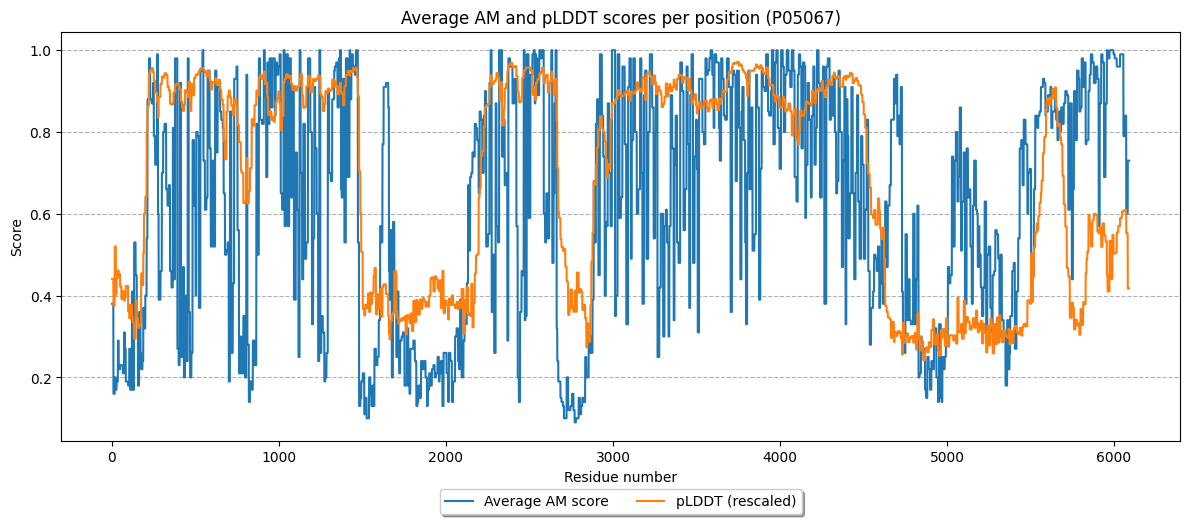

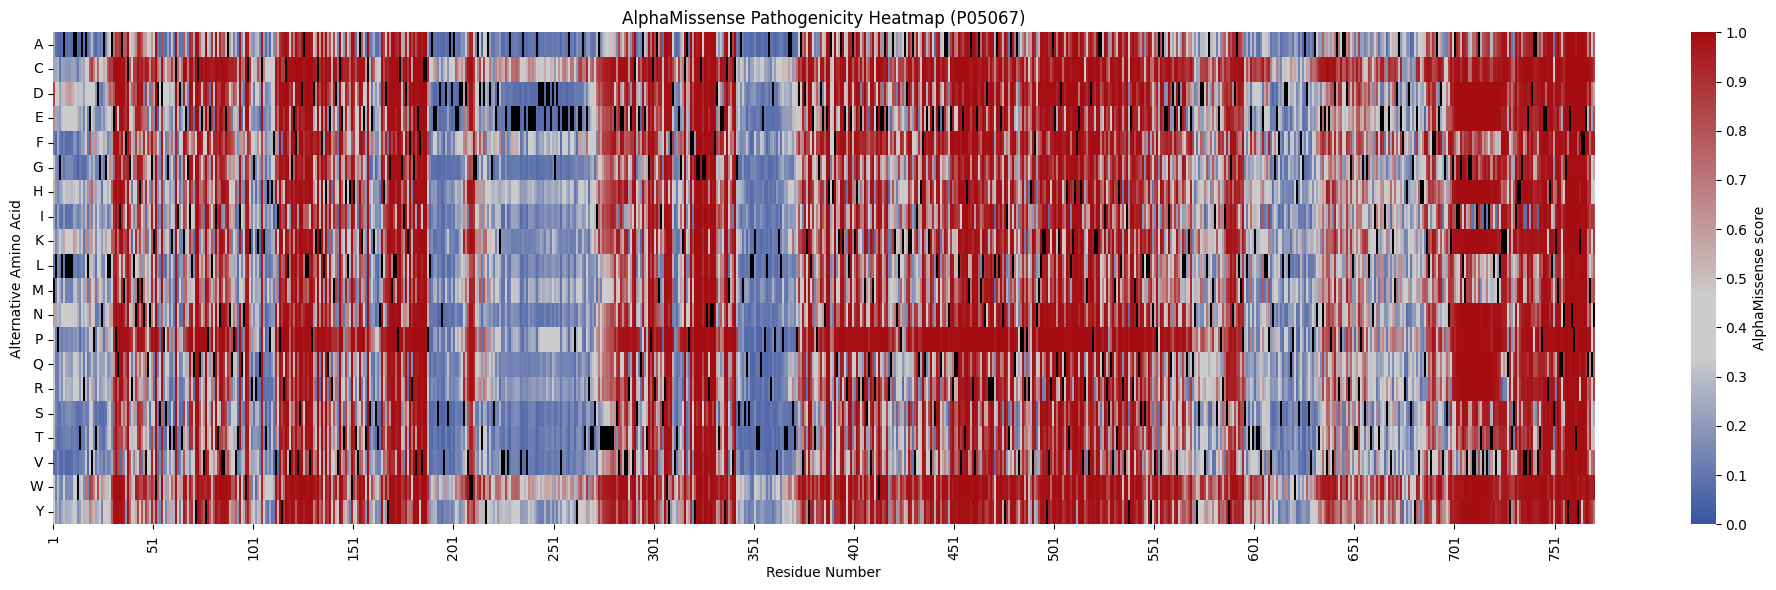

Q9Y5P2


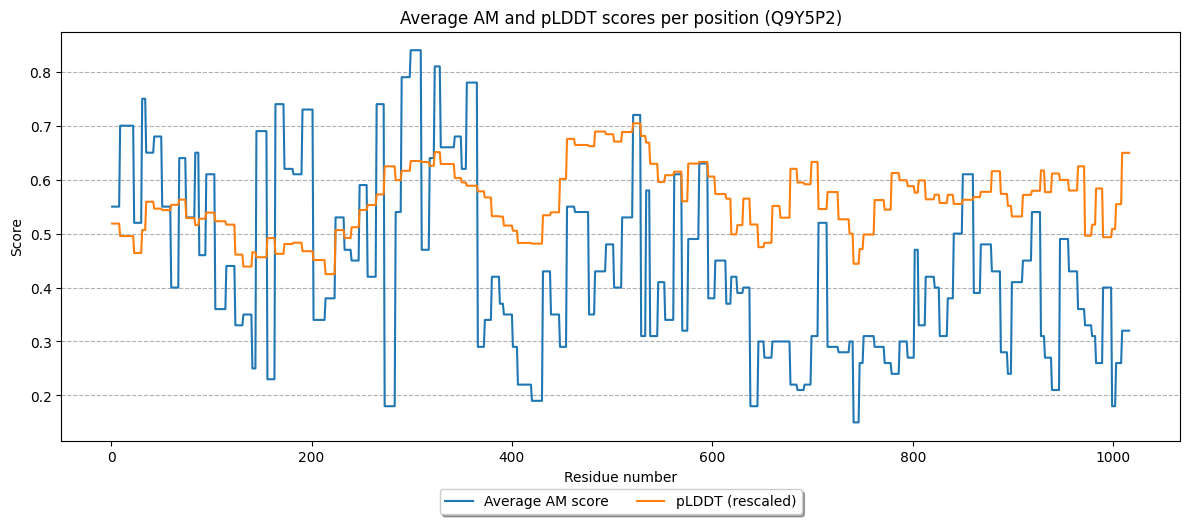

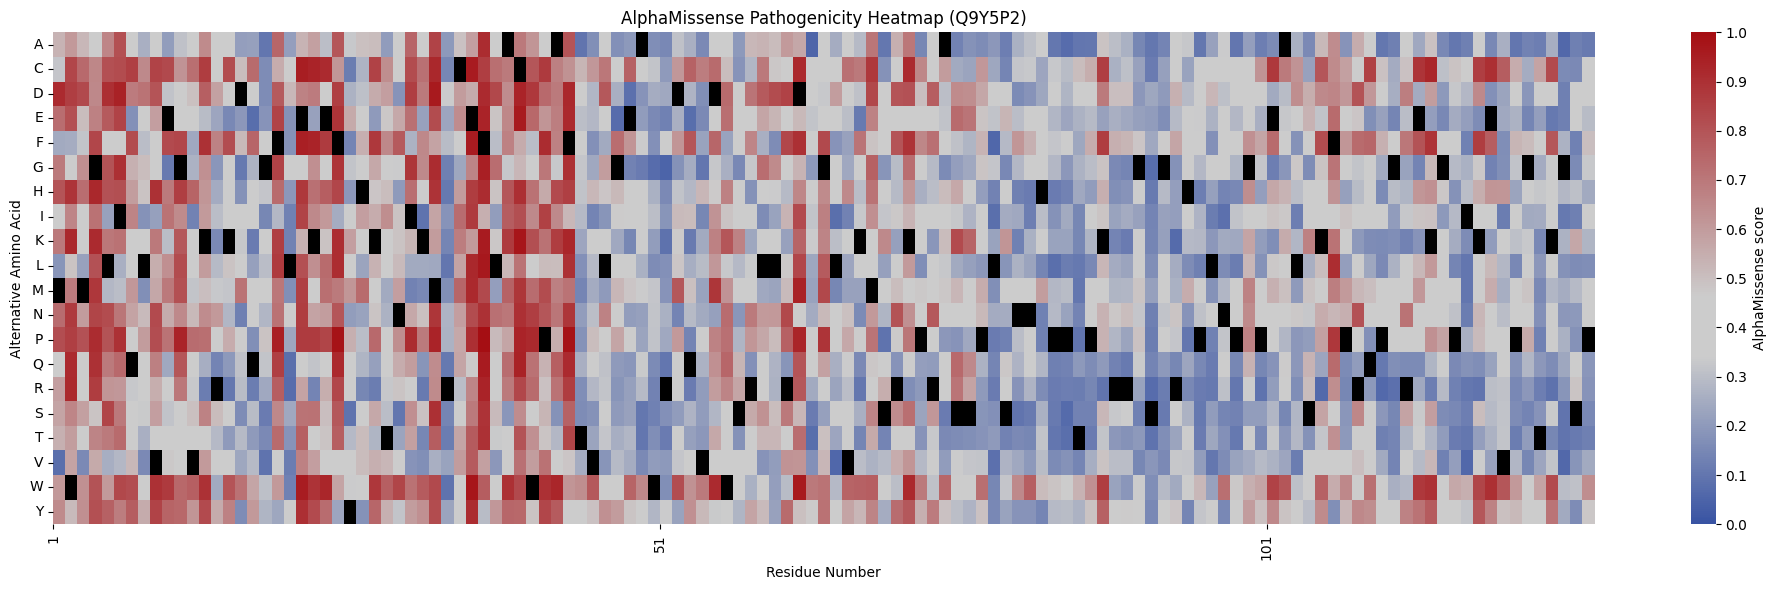

In [15]:
#@title <font color='#e59454'>Show plddt vs average AlphaMissense plots & AlphaMissense heatmap
output_directory = "data_output"
ensure_directory_exists(output_directory)

for uniprot_id in uniprot_ids:
  alphafold_data = fetch_AFDB_data(uniprot_id)
  if alphafold_data:
    am_data=extract_am_data(am_url=extract_alpha_missense_url(alphafold_data))
    pdb_data_url = extract_pdb_url(alphafold_data)
    modify_pdb_with_am_data(pdb_data_url, average_scores_file=calculate_average_pathogenicity(am_data))
    file_path= f"data_output/AM_scores_AF-{uniprot_id}-F1-model_v4.pdb"
    pathogenicity_scores, plddt_scores = extract_pathogenicity_and_plddt(file_path, pdb_data_url)

    print(uniprot_id)
    plot_scores(pathogenicity_scores, plddt_scores, uniprot_id)
    plot_am_heatmap(am_data, uniprot_id)

In [16]:
#@title <font color='#e59454'>Downloading Results

#@markdown This cell creates a zip file containing the generated plots and modified PDB files, allowing you to easily download and save your results. Here's what's happening:

#@markdown  * **Gathering Files**: The code collects all the generated plot images (in PNG format) and the modified PDB files where the B-factor column now holds the AlphaMissense scores.

#@markdown  * **Creating a Zip Archive**:  A zip file named results.zip is created within the Colab environment.

#@markdown  * **Adding** **Files**: All the collected plot images and modified PDB files are added to this results.zip archive.

#@markdown  * **Downloading** **the** **Zip** **File**: This cell will initiate a download of this results.zip file to your local machine. You'll typically see a download prompt in your browser.




# Zip the extracted files
import zipfile
from pathlib import Path
from google.colab import files


folder = Path("./data_output/")
zip_filename = "AM_files.zip"

# Create a zip archive
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in folder.iterdir():  # Use iterdir() to iterate over files
        if file.is_file():  # Check if it's a file
            zipf.write(file, arcname=file.name)  # Add file to zip with only the file name
            os.remove(file)  # Remove the file after adding to zip

print(f"Created zip archive: {zip_filename}")

    # Download the zip file
files.download(zip_filename)

Created zip archive: AM_files.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>